In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import time
from matplotlib import animation
from IPython.display import HTML
import scipy.constants as const
import scipy.fftpack as ft

Following J. Chem. Phys. 99, 1185 (1993); https://doi.org/10.1063/1.465362
$$i\frac d{dt}\left(\begin{array}{cc}\Psi_1(t)\\ \Psi_2(t)\end{array}\right) =
\left(\begin{array}{cc} 
\frac{\hat p^2}{2μ} + V_g & −D × E(t)\\ 
−D × E(t) & \frac{\hat p^2}{2μ} + V_u
\end{array}\right)
\left(\begin{array}{cc}\Psi_1(t)\\ \Psi_2(t)\end{array}\right)$$
using
$$\mathbf T=-\frac{\hbar^2}{2\mu}\left(\begin{array}{cc} 1/\text{d}x^2&0\\0&  1/\text{d}x^2\end{array}\right)$$
$$\mathbf V(t)=\left(\begin{array}{cc}V_g & −D × E(t)\\ 
−D × E(t) & V_u
\end{array}\right)$$
We get for a time step $\Delta t$:
$$\Psi(t+\Delta t) = \text{exp}\left[\Delta t \mathbf T+\Delta t \mathbf V(t+\Delta t/2)\right]\Psi(t)+\mathcal O(\Delta t^3)$$

the following functions calculate $\text{exp}\left[\lambda \mathbf T\right]$ and $\text{exp}\left[\lambda \mathbf V(t)\right]$

In [ ]:
#Daten aus Paper genommen(seite 4)

In [ ]:
class state:
    def __init__(self,initial1,initial2,Vg,Vu,D,Ekin,npoints,L,tau,m=1):
        #initial state
        self.ini1=initial1
        self.ini2=initial2
        #current state that is updated after advancing in time
        self.Psi1=initial1
        self.Psi2=initial2
        #storage of all states visited
        self.Psi1t=[initial1]
        self.Psi2t=[initial2]
        self.Ekin=Ekin
        self.Vg=Vg
        self.Vu=Vu
        self.D=D
        self.t=0
        self.N=npoints
        self.L=L
        self.m=m
        self.tau=tau
    def advance(self,dt):
        #raise
        #first potential step
        Psi1 = np.exp(-1j*self.Vg*dt/2)*self.Psi1
        Psi2 = np.exp(-1j*self.Vu*dt/2)*self.Psi2
        
        #applying unitary matrices
        Psi1n = 1/np.sqrt(2)*(Psi1+Psi2)
        Psi2n = 1/np.sqrt(2)*(Psi1-Psi2)
        #time dependent potential step
        Psi1 = np.exp(-1j*dt*self.D*DE(self.t+dt/2,self.tau))*Psi1n
        Psi2 = np.exp(1j*dt*self.D*DE(self.t+dt/2,self.tau))*Psi2n
        #unitary again
        Psi1n = 1/np.sqrt(2)*(Psi1+Psi2)
        Psi2n = 1/np.sqrt(2)*(Psi1-Psi2)
        #final potential step
        Psi1 = np.exp(-1j*self.Vg*dt/2)*Psi1n
        Psi2 = np.exp(-1j*self.Vu*dt/2)*Psi2n
        
        Psi1 = np.fft.fft(Psi1)          # Fourier transform
        Psi2 = np.fft.fft(Psi2)
        Psi1k = np.exp(-1j*self.Ekin*dt)*Psi1      # advance in Fourier space
        Psi2k = np.exp(-1j*self.Ekin*dt)*Psi2 
        self.Psi1 = np.fft.ifft(Psi1k)          # return to real space
        self.Psi2 = np.fft.ifft(Psi2k)
        self.t+=dt
    def evolution(self,tsteps,dt):
        dx = self.L/self.N
        xvals = np.linspace(-self.L/2,self.L/2,self.N,endpoint=False)
        kvals = 2*np.pi*np.fft.fftfreq(self.N,d=dx)
        # propagate the wave packet
        tvec = np.linspace(0,tsteps*dt,tsteps+1) # will have length tsteps+1
        # container for storing the result
        psit = 0j*np.zeros((tsteps+1,self.N))
        # store initial value
        psit[0] = self.ini

        for i in range(tsteps):
            # apply potential
            psi = np.exp(-1j*dt*self.V)*psit[i]
            # go to Fourier space
            psi = np.fft.fft(psi)
            # apply kinetic part
            psi = np.exp(-1j*dt*kvals**2/(2*self.m))*psi
            # go back to real space
            psi=np.fft.ifft(psi)
            # store the result
            psit[i+1] = psi
        self.psit=psit
    def get(self):
        return self.Psi1,self.Psi2
    
    def reset(self):
        self.Psi1=self.ini1
        self.Psi2=self.ini2
        self.t=0
        #self.V=self.V0

In [ ]:
#atomic units
nm=1e-9/5.2917721092e-11
fs=1e-15/2.418884326505e-17
epsilon0=1/(4*np.pi*1.054571726e-34)
c=137
theta=0

In [ ]:
lam=760*nm
I0=5.1e12
w=c/lam*2*np.pi
E0=np.sqrt(2*I0/8.854187817e-12/299792458)/5.14220652e11
E=E0*np.cos(theta)
sigfwhm=8.6*fs

In [122]:
def DE(t,tau,sig=sigfwhm,E=E,w=w):
     return E*np.cos(w*t)*np.exp(-(t-tau)**2/(2*sig**2))

In [129]:
m = 938.28/0.511/2
#L = 30
#Ngrid = 600
tau=0

_,Vg=np.loadtxt('data/H2p_pot_gerade.dat',unpack=True)
_,Vu=np.loadtxt('data/H2p_pot_ungerade.dat',unpack=True)
xd,D=np.loadtxt('data/dipole_coupling.dat',unpack=True)
_,Psi0=np.loadtxt('data/H2nuclwf.dat',unpack=True)
Psii=Psi0/np.linalg.norm(Psi0)

#x space
#dx = 5e-2#L/(Ngrid)
x = xd[1:-1]#np.linspace(dx,L,Ngrid)
dx= np.mean(np.diff(x))
k = 2*np.pi*ft.fftfreq(x.size,d = dx)
#k = ft.fftshift(k)
dk = np.diff(k).mean()
k0=0
Ekin = k**2/(2*m)

In [130]:
#    def __init__(self,initial1,initial2,V,npoints,L,tau,m=1):
Psi=state(Psii[5:200],np.zeros(195),Vg[5:200],Vu[5:200],D[1:-1],Ekin,195,tau,m)

In [131]:
#plt.plot(x,Psi.get()[0])

In [132]:
dt,tsteps=1.5e0,500

#Psi.evolution(tsteps,dt)

In [133]:
Psi.reset()
Psit1=[]
Psit2=[]
for t in np.arange(0,dt*tsteps,dt):
    #print(t)
    Psi.advance(dt)
    Psi1,Psi2=Psi.get()
    Psit1.append(Psi1)
    Psit2.append(Psi2)


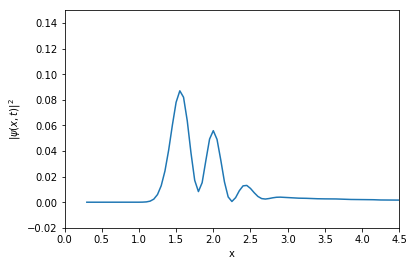

In [134]:
fig, ax = plt.subplots()
ax.set_xlim(( 0,4.5))
ax.set_ylim((-.02,.15))
ax.set_xlabel("x")
ax.set_ylabel("$|\psi(x,t)|^2$")
line, = ax.plot([],[])

def animate(it):
    y = np.abs(Psit1[it])**2
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,tsteps,1), # t-values
                               interval=50, # wait time before displaying new frame in ms
                               blit=True)

HTML(anim.to_jshtml())

In [150]:
px=-1j/dx*np.diag(np.ones(195))

taus=np.linspace(0,70*fs,100)
imp=1j*np.zeros((tsteps,len(taus)))

In [152]:
for j in range(len(taus)):
    Psi.reset()
    Psi.tau=taus[j]
    Psit1=[]
    #Psit2=[]
    for t in np.arange(0,dt*tsteps,dt):
        Psi.advance(dt)
        Psi1,Psi2=Psi.get()
        Psit1.append(Psi1)
        #Psit2.append(Psi2)
    for i in range(tsteps):
        imp[i,j]=Psit1[i].T.conj()@px@Psit1[i]
    print(j,end='\r')    

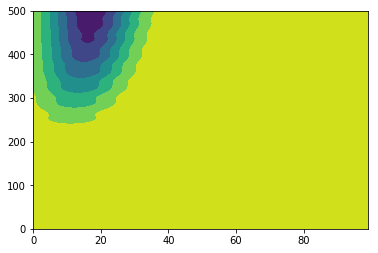

In [154]:
plt.contourf(np.abs(imp)**2)

NameError: name 'Vpot' is not defined

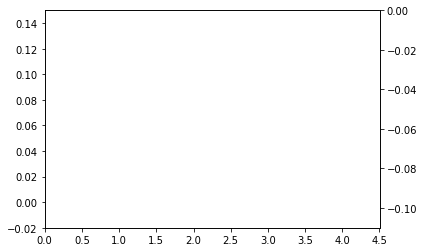

In [135]:
fig, ax1 = plt.subplots()
# add axis specifications
line, = ax1.plot([],[],label='$|\Psi(x,t)|^2$')
plt.ylim(-.02,.15)
plt.xlim(0,4.5)
ax2=ax1.twinx()
plt.ylim(-.11,0)
linePot, = ax2.plot(x,Vpot[:Ngrid],color='black',lw=1,label='$V(x,t)$')
plt.legend()
plt.xlabel('x')
#plt.ylabel('wave function')
plt.title('Wave packet propagation without IR laser')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

def animate(t):
    print('%.1f%s'%(100*t/tsteps,'%'),end='\r')
    line.set_data(x,np.abs(Psi.psit[int(t)])**2)
    return (line,)

anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,tsteps,1), # t-values
                               interval=50, # wait time before displaying new frame in ms
                               blit=True)